# Curso NLP y DeepLearning
## Actividad 2 y TP Final: Redes neuronales
### Damián A. Fernández
### CoderHouse - Comisión 60900 (2024)

# Descripción de proyecto
Este proyecto se trata de una práctica integradora del módulo Deep Learning del curso "DataScience III: NLP y Deep Learning".
Se tomó el dataset preprocesado con herramientas de NLP durante la Actividad 1, para comparar el rendimiento de modelos predictivos convencionales y uno de redes neuronales como clasificadores binarios.


### Hipótesis
Verificar la posibilidad de detectar el sentimiento subyacente de los mensajes, inicialmente de forma polarizada (positivo o negativo).


### Objetivos
#### General
- Desarrollar una comparativa de modelos analizadores de sentimiento de forma polarizada (positivo/negativo) a partir de un dataset de tweets en español etiquetados por positivo o no-positivo que fue procesado con herramientas de NLP en la Actividad 1.

#### Específicos
- Dividir el dataset en conjuntos de train, validation y test (se utiliza el dataset preprocesado de la Actividad 1).
- Desarrollo de un modelo Naive Bayes Gaussiano
- Desarrollo de un modelo de Regresión Logística
- Desarrollo de un modelo de Regresión Logística optimizado con GridSearch
- Desarrollo de un modelo de redes neuronales optimizado con RandomizeSearch.
- Evaluación de los modelos.
- Desarrollo de una clase para implementación del clasificador.

### Descripción de dataset

Se trabajará con la versión preprocesada en la Actividad 1 (dataset original: tweets en español disponible en kaggle.com. Fuente: https://www.kaggle.com/datasets/philipsanm/sentiment-analysis-in-spanish-tweets)

# Librerias necesarias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 22.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [20]:
import pandas as pd
import numpy as np
import spacy
import es_core_news_md
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
from scikeras.wrappers import KerasClassifier          # Wrapper de modelos para poder implementar sklearn.RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

## Funciones para evaluación de modelos

In [2]:
def scores_from_true_hat(nombre, y_true, y_hat):
    TN, FP, FN, TP = confusion_matrix(y_true, y_hat).ravel()
    y_true_p = (y_true == 1).sum()
    y_true_n = (y_true == 0).sum()
    ratios = [TN/y_true_n, FP/y_true_p, FN/y_true_n, TP/y_true_p]
    #rint(f'TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    accuracy = np.round(accuracy_score(y_true, y_hat), 3)
    recall = np.round(recall_score(y_true, y_hat), 3)
    precision = np.round(precision_score(y_true, y_hat),3)
    specificity = np.round((TN/(TN+FP)), 3)
    f1 = np.round(f1_score(y_true, y_hat), 3)
    df_scores = pd.Series([accuracy, precision, recall, specificity, f1, *[round(x, 2) for x in ratios]],
                       index=['accuracy', 'precision', 'recall', 'specificity', 'f1', 'TN_N_ratio', 'FP_P_ratio', 'FN_N_ratio', 'TP_P_ratio'],
                      name=nombre)
    return df_scores

def plot_matrix(nombre, y_true, y_hat):
    cm = confusion_matrix(y_true, y_hat)
    sns.heatmap(cm, annot=True, fmt='4d', cmap='Blues')
    plt.xlabel('Predicción'), plt.ylabel('Reales')
    plt.title('Matriz de confusión - ' + nombre, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_roc_auc(model, nombre, X, y_true):
    y_pred_proba = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr = thresholds))

    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificity')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve - ' + nombre, fontsize=14)
    plt.plot(df['fpr'],df['tpr'], linewidth=2, color='#253278')
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linewidth=2, color='#5c98a2', linestyle='--')
    plt.tight_layout()
    plt.show()
    auc_ = auc(fpr,tpr).round(3)
    print(f'AUC: {auc_}')
    return auc_

def plot_roc_auc_from_proba(nombre, y_true, y_hat_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_hat_proba)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr = thresholds))

    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificity')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve - ' + nombre, fontsize=14)
    plt.plot(df['fpr'],df['tpr'], linewidth=2, color='#253278')
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linewidth=2, color='#5c98a2', linestyle='--')
    plt.tight_layout()
    plt.show()
    auc_ = auc(fpr,tpr).round(3)
    print(f'AUC: {auc_}')
    return auc_

In [187]:
df_summary_scores = pd.DataFrame()

# Lectura de datos

### Importación de archivo pickle con dataset preprocesado en Actividad 1

In [219]:
file = 'https://raw.githubusercontent.com/damianmdp/ch_nlp_dl/main/tweets_dataset_tokens.pkl'
df_token = pd.read_pickle(file)

In [220]:
df_token.sample(5)

,positive_sentiment,text_tokens
589,False,molestar vacación hora volver aparta 🏃 🏽‍ ♀ ️
2170,True,to incredulo
144,False,negar sentir yo avergonzado forma amé negar se...
339,False,gobierno verdad medias mentiroso gobierno coma...
143,False,avergonzado profundidad amor elegir amarte cos...


In [143]:
X = df_token['text_tokens']
y = df_token['positive_sentiment']

In [144]:
X.shape, y.shape

((2189,), (2189,))

# Modelo con Machine Learning

### División de datos en conjuntos de entrenamiento, validación y prueba

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [146]:
X_train.shape, X_test.shape

((1532,), (657,))

### Vectorización TF-IDF de Scikit-Learn

In [173]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Modelo de Naive Bayes Gaussiano

In [174]:
nombre = 'Naive Bayes Gaussiano'
model_nb = GaussianNB()
model_nb.fit(X_train_tfidf.toarray(), y_train)

GaussianNB()

### Evaluación

#### Scores

In [188]:
y_test_hat = model_nb.predict(X_test_tfidf.toarray())
scores = scores_from_true_hat(nombre, y_test, y_test_hat)
df_summary_scores = pd.concat([df_summary_scores, scores], axis=1)
scores[0:5].to_frame(name='score')

,score
accuracy,0.674
precision,0.709
recall,0.682
specificity,0.666
f1,0.695


#### Matriz de confusión

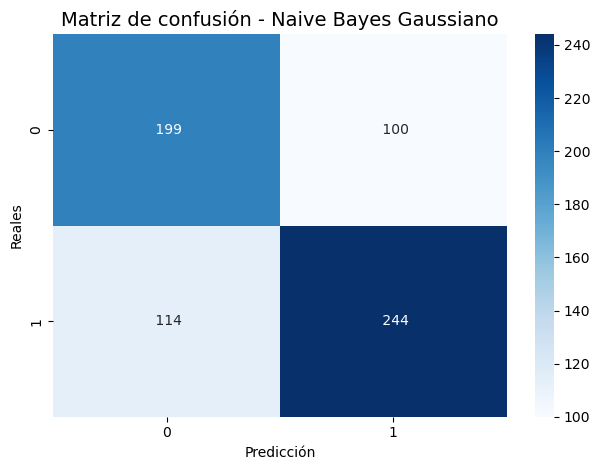

In [191]:
plot_matrix(nombre, y_test, y_test_hat)

#### Gráfico de curva ROC y cálculo de área bajo la curva

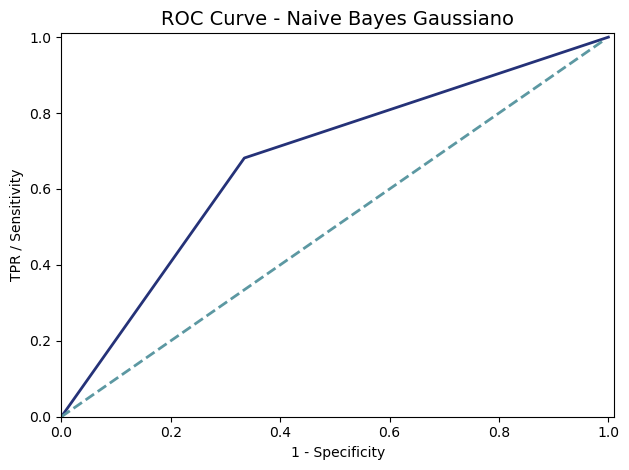

AUC: 0.674


In [192]:
auc_metric = plot_roc_auc(model_nb, nombre, X_test_tfidf.toarray(), y_test)
df_summary_scores.loc['AUC', nombre] = auc_metric

## Modelo de Regresión Logística

In [193]:
nombre = 'Regresión Logística'
model_lr = LogisticRegression()
model_lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [194]:
model_lr.intercept_, model_lr.coef_

(array([0.24362105]),
 array([[ 0.22228706, -0.10122098,  0.21887191, ..., -0.16058861,
         -0.16058861,  0.08230998]]))

### Evaluación

#### Scores

In [195]:
y_test_hat = model_lr.predict(X_test_tfidf)
scores = scores_from_true_hat(nombre, y_test, y_test_hat)
df_summary_scores = pd.concat([df_summary_scores, scores], axis=1)
scores[0:5].to_frame(name='score')

,score
accuracy,0.801
precision,0.745
recall,0.964
specificity,0.605
f1,0.840


#### Matriz de confusión

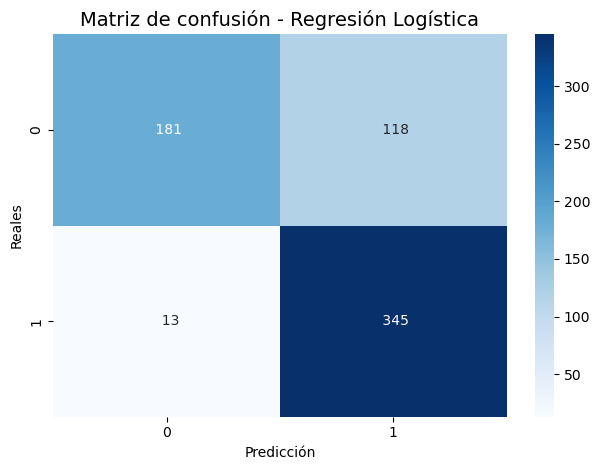

In [196]:
plot_matrix(nombre, y_test, y_test_hat)

#### Gráfico de curva ROC y cálculo de área bajo la curva

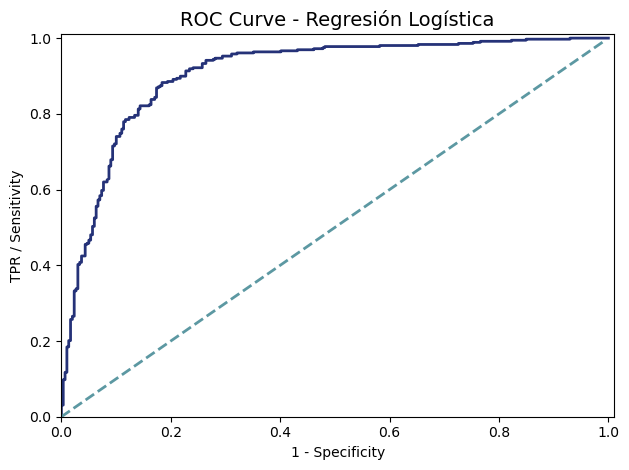

AUC: 0.906


In [197]:
auc_metric = plot_roc_auc(model_lr, nombre, X_test_tfidf, y_test)
df_summary_scores.loc['AUC', nombre] = auc_metric

## Modelo de Regresión Logística optimizado con GridSearch

In [158]:
nombre = 'Regresión Logística Optimizado GS'
model_lr = LogisticRegression()

In [159]:
folds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [80]:
#c_arr = [0.0001,0.001,0.01,0.1]
c_arr = [0.001, 0.01, 1, 10, 15, 20, 40, 80, 120]
params_grid = {'penalty': ['l2'], 'C': c_arr, 'solver': ['saga']}

In [81]:
grid_lr = GridSearchCV(model_lr, params_grid, cv=folds, scoring='accuracy', n_jobs=-1)

In [82]:
grid_lr.fit(X_train_tfidf.toarray(), y_train)

C:\Users\Damian\miniconda3\envs\datascience2024\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 1, 10, 15, 20, 40, 80, 120],
                         'penalty': ['l2'], 'solver': ['saga']},
             scoring='accuracy')

In [160]:
grid_lr.best_params_

{'C': 80, 'penalty': 'l2', 'solver': 'saga'}

In [161]:
grid_lr.best_score_

0.8557578080091972

In [162]:
lr_best = grid_lr.best_estimator_

In [163]:
lr_best.coef_

array([[ 0.8770423 , -0.64631702,  0.90175369, ..., -1.41670422,
        -1.41670422,  0.33447404]])

### Evaluación

#### Scores

In [198]:
y_test_hat = lr_best.predict(X_test_tfidf)
scores = scores_from_true_hat(nombre, y_test, y_test_hat)
df_summary_scores = pd.concat([df_summary_scores, scores], axis=1)
scores[0:5].to_frame(name='score')

,score
accuracy,0.865
precision,0.846
recall,0.919
specificity,0.799
f1,0.881


#### Matriz de confusión

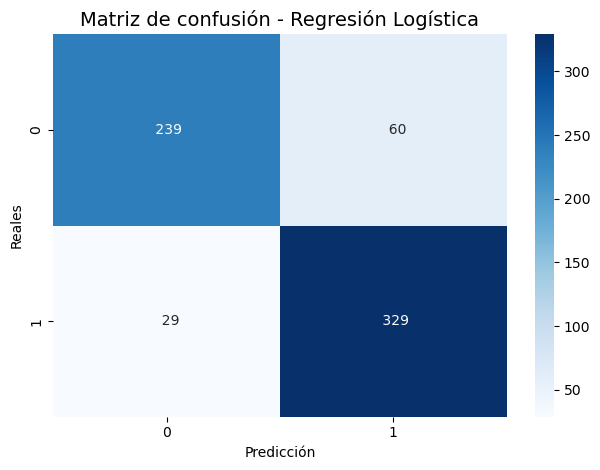

In [199]:
plot_matrix(nombre, y_test, y_test_hat)

#### Gráfico de curva ROC y cálculo de área bajo la curva

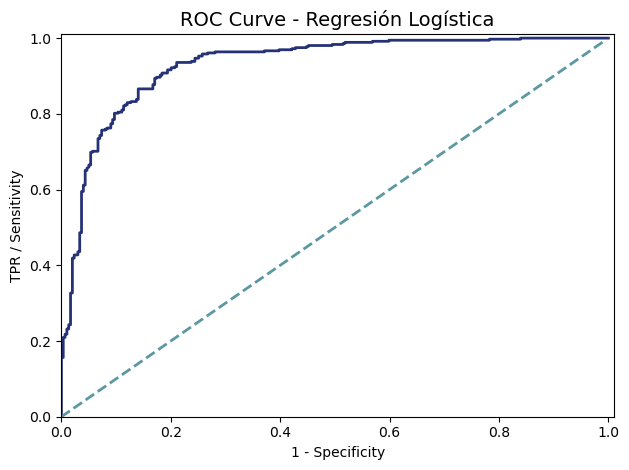

AUC: 0.93


In [200]:
auc_metric = plot_roc_auc(lr_best, nombre, X_test_tfidf, y_test)
df_summary_scores.loc['AUC', nombre] = auc_metric

# Modelo con Deep Learning

### División de datos en conjuntos de entrenamiento, validación y prueba

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [93]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.333, random_state=42)

In [94]:
X_train.shape, X_val.shape, X_test.shape

((1532,), (438,), (219,))

## Vectorización con keras.TextVectorization

In [95]:
keras_vectorizer = TextVectorization(standardize=None, ngrams=None, max_tokens=10000, output_mode='tf-idf')

In [96]:
keras_vectorizer.adapt(X_train)

In [97]:
vocab_size = keras_vectorizer.vocabulary_size()
vocab_size

6644

### Vectorización de conjuntos train y val

In [98]:
X_train_kv, X_val_kv = keras_vectorizer(X_train), keras_vectorizer(X_val)

## Red neuronal optimizada con sklearn.RandomizedSearch

### Función de creación parametrizada de modelo de redes neuronales

In [ ]:
def generar_rn(max_feat, n_hidden, neurons_decay, dropout_rate):
    
    print(f'n_hidden={n_hidden}, neurons_decay={neurons_decay}, dropout_rate={dropout_rate}')
    
    n_neurons = [int(max_feat*(neurons_decay**i)) for i in range(n_hidden)]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(max_feat,)))
    for capa in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons[capa], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Capas ocultas
        if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #Capa de salida
    model.compile(
                loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()]
                )
    return model

#### Instanciación con wrapper de scikeras para mimetizar red neuronal con clasificador de scikit-learn

In [ ]:
keras_clasif = KerasClassifier(model=generar_rn, max_feat=vocab_size, n_hidden=1, neurons_decay=0.5, dropout_rate=0.3, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

### RandomizedSearchCV

In [185]:
params = {
    'n_hidden': [1, 2, 3],
    'neurons_decay': [0.25, 0.5],
    'dropout_rate': [0.3, 0.5]
}
params

{'n_hidden': [1, 2, 3],
 'neurons_decay': [0.25, 0.5],
 'dropout_rate': [0.3, 0.5]}

In [19]:
rnd_search_cv = RandomizedSearchCV(estimator=keras_clasif, param_distributions=params, n_iter=5, cv=3)

In [20]:
rnd_search_cv.fit(X_train_kv.numpy(), y_train,
                epochs=50,
                validation_data=(X_val_kv.numpy(), y_val),
                callbacks=[early_stopping])

n_hidden=3, neurons_decay=0.25, dropout_rate=0.5
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.5980 - auc: 0.5851 - f1_score: 0.7282 - loss: 57.6914 - val_accuracy: 0.6826 - val_auc: 0.7862 - val_f1_score: 0.7022 - val_loss: 7.4332
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8941 - auc: 0.9446 - f1_score: 0.7179 - loss: 4.6854 - val_accuracy: 0.7671 - val_auc: 0.8248 - val_f1_score: 0.7022 - val_loss: 1.6231
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9592 - auc: 0.9837 - f1_score: 0.7342 - loss: 0.9804 - val_accuracy: 0.7603 - val_auc: 0.8250 - val_f1_score: 0.7022 - val_loss: 1.1076
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9727 - auc: 0.9885 - f1_score: 0.7304 - loss: 0.5424 - val_accuracy: 0.7717 - val_auc: 0.8352 - val_f1_score: 0.7022 - val_loss: 0.9239
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9803 - auc: 0.9944 - f1_score: 0.7090 - loss: 0.4303 - val_accuracy: 0.8219 - v

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7e81521c94e0>], dropout_rate=0.3, max_feat=6644, model=<function generar_rn at 0x7e80cfedbac0>, n_hidden=1, neurons_decay=0.5),
                   n_iter=5,
                   param_distributions={'dropout_rate': [0.3, 0.5],
                                        'n_hidden': [1, 2, 3],
                                        'neurons_decay': [0.25, 0.5]})

In [21]:
rnd_search_cv.best_params_

{'neurons_decay': 0.25, 'n_hidden': 3, 'dropout_rate': 0.5}

In [26]:
rnd_search_cv.best_score_

0.829633040430784

### Generación de red neuronal con parámetros optimizados

In [101]:
n_hidden = 3
neurons_decay = 0.25
dropout_rate = 0.5

In [102]:
keras_vectorizer = TextVectorization(standardize=None, ngrams=None, max_tokens=10000, output_mode='tf-idf', encoding='utf-8')
keras_vectorizer.adapt(X_train)
max_feat = keras_vectorizer.vocabulary_size()

In [103]:
n_neurons = [int(max_feat*(neurons_decay**i)) for i in range(n_hidden)]

In [221]:
new_model = tf.keras.models.Sequential()
new_model.add(keras_vectorizer) # Capa de vectorización
for capa in range(n_hidden):
    new_model.add(tf.keras.layers.Dense(n_neurons[capa], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Capas ocultas
    if dropout_rate > 0: new_model.add(tf.keras.layers.Dropout(dropout_rate))
new_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #Capa de salida

In [105]:
new_model.compile(
            loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy', tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()]
            )

In [106]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [107]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#checkpoint = tf.keras.callbacks.ModelCheckpoint("new_model_bal_randomsearch.keras", save_best_only=True)
history = new_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - accuracy: 0.5636 - auc: 0.5591 - f1_score: 0.7155 - loss: 47.8355 - val_accuracy: 0.7306 - val_auc: 0.7879 - val_f1_score: 0.7022 - val_loss: 2.4700
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.8565 - auc: 0.9119 - f1_score: 0.7037 - loss: 1.5754 - val_accuracy: 0.8196 - val_auc: 0.8651 - val_f1_score: 0.7022 - val_loss: 0.9837
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - accuracy: 0.9483 - auc: 0.9876 - f1_score: 0.7171 - loss: 0.6099 - val_accuracy: 0.8105 - val_auc: 0.8775 - val_f1_score: 0.7022 - val_loss: 0.8004
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.9563 - auc: 0.9882 - f1_score: 0.7221 - loss: 0.4542 - val_accuracy: 0.8196 - val_auc: 0.8818 - val_f1_score: 0.7022 - val_loss: 0.7647
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 570ms/step - accuracy: 0.9623 - auc: 0.9898 - f1_score: 0.7121 - loss: 0.4103 - val_accuracy: 0.7877 - val_auc: 0.8797 - val_f1_score: 0.7022 - v

In [109]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 6644)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6644)                │      44,149,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6644)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1661)                │      11,037,345 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1661)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 415)                 │         689,730 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 415)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,753,744 (426.31 MB)

 Trainable params: 55,876,871 (213.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,876,873 (213.15 MB)

(0.0, 1.0)

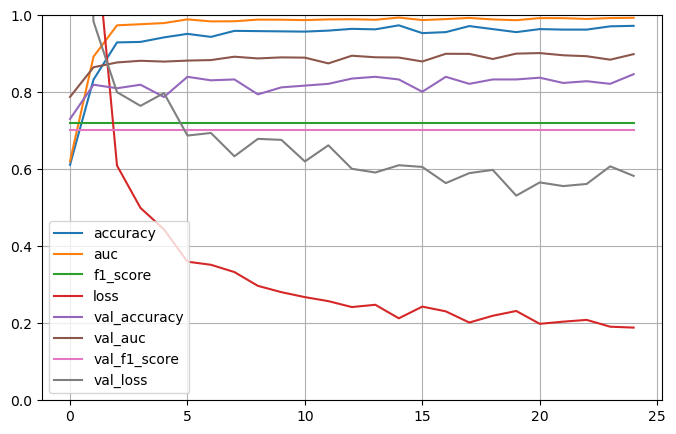

In [110]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

### Evaluación

#### Scores

In [201]:
nombre = 'Red neuronal'
y_test_hat_proba = new_model.predict(X_test)
y_test_hat = (y_test_hat_proba > 0.5).astype("int32")

scores = scores_from_true_hat(nombre, y_test, y_test_hat)
df_summary_scores = pd.concat([df_summary_scores, scores], axis=1)
scores[0:5].to_frame(name='score')

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


,score
accuracy,0.848
precision,0.839
recall,0.891
specificity,0.796
f1,0.864


#### Matriz de confusión

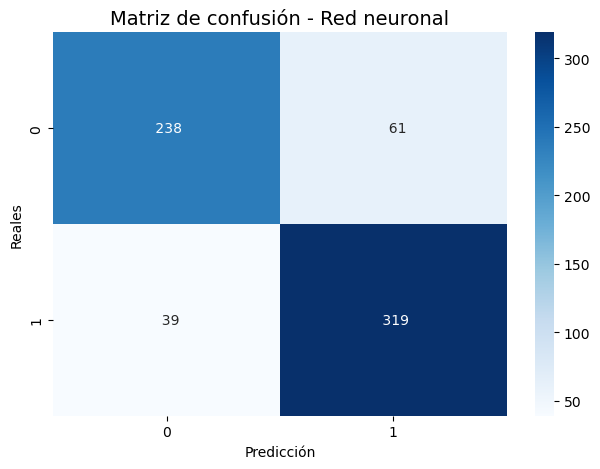

In [202]:
plot_matrix('Red neuronal', y_test, y_test_hat)

#### Gráfico de curva ROC y cálculo de área bajo la curva

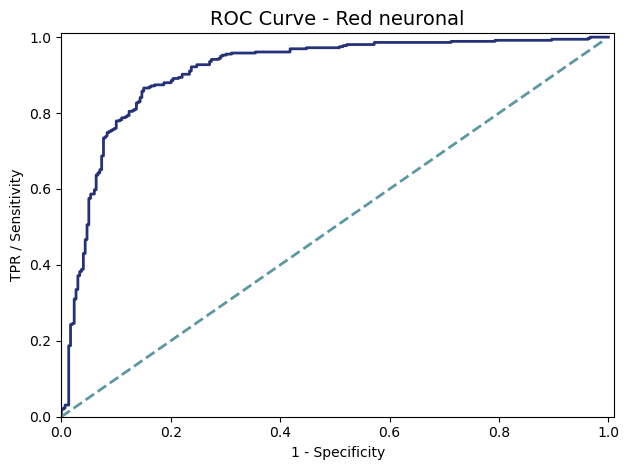

AUC: 0.91


In [203]:
auc_metric = plot_roc_auc_from_proba('Red neuronal', y_test, y_test_hat_proba)
df_summary_scores.loc['AUC', nombre] = auc_metric

# Resultados

In [205]:
df_summary_scores.T

,accuracy,precision,recall,specificity,f1,TN_N_ratio,FP_P_ratio,FN_N_ratio,TP_P_ratio,AUC
Naive Bayes Gaussiano,0.674,0.709,0.682,0.666,0.695,0.67,0.28,0.38,0.68,0.674
Regresión Logística,0.801,0.745,0.964,0.605,0.840,0.61,0.33,0.04,0.96,0.930
Regresión Logística,0.865,0.846,0.919,0.799,0.881,0.80,0.17,0.10,0.92,0.930
Red neuronal,0.848,0.839,0.891,0.796,0.864,0.80,0.17,0.13,0.89,0.910


Text(0.5, 1.0, 'Resumen de scores obtenidos \n')

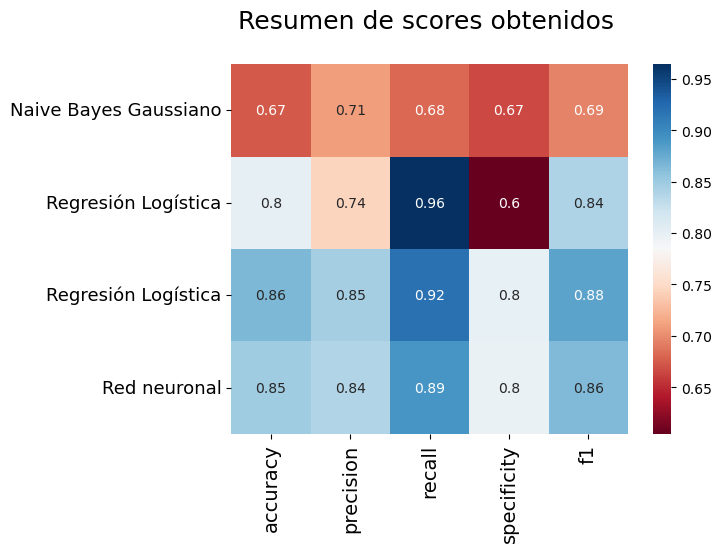

In [210]:
sns.heatmap(df_summary_scores.T[['accuracy', 'precision', 'recall', 'specificity', 'f1']], annot=True, cmap='RdBu')
plt.yticks(fontsize=13)
plt.xticks(rotation=90, fontsize=14)
plt.title('Resumen de scores obtenidos \n', fontsize=18)

## Clase para implementación de predictor

In [211]:
#checkpoint_file = 'drive/MyDrive/Colab Notebooks/best_model_randomsearch.h5'
#checkpoint_file = 'best_model_randomsearch.keras'
#model_from_file = tf.keras.models.load_model(checkpoint_file)

In [212]:
class AnalizadorDeSentimiento():
    def __init__(self, model, vectorizer, verbose=False):
        self.model = model
        self.vectorizer = vectorizer
        self.texto = ''
        self.sentimiento = None
        self.doc_vector = None
        self.verbose = verbose

    def preprocesar(self, texto):
        self.texto = texto
        if self.verbose: print(f'Texto original: {self.texto}')
        self.nlp = es_core_news_md.load()
        self.doc = self.nlp(self.texto)
        if self.verbose: print(f'Texto procesado con spacy: {self.doc}')
        self.doc = [token for token in self.doc if
                    not token.is_stop and
                    not token.is_punct and
                    not token.is_space and
                    token.pos_ != 'SYM'
                    ]
        if self.verbose: print(f'Tokens antes de lematización: {self.doc}')
        self.doc = ' '.join([token.lemma_ for token in self.doc])
        if self.verbose: print(f'Tokens después de limpieza: {self.doc}')
        
        self.doc_vector = self.vectorizer(self.doc)
        if self.verbose: print(f'Dimensiones de vector preprocesado: {self.doc_vector.shape}') # | Tipo: {type(self.doc_vector)}')

    def analizar(self):
        if self.doc_vector == None: print('Es neceario ejecutar el método preprocesar')
        
        self.sentiment_proba = self.model.predict(pd.Series(self.doc))
        if self.verbose: print(f'Probabilidad de positivismo: {self.sentiment_proba}')
        return "El sentimiento es POSITIVO" if (self.sentiment_proba > 0.5) else "El sentimiento es NEGATIVO"

### Implementación de red neuronal como predictor

In [213]:
analizador = AnalizadorDeSentimiento(new_model, keras_vectorizer, verbose=True)

In [214]:
analizador.preprocesar('Estoy muy bien es lo mejor que sentí en la vida')
analizador.analizar()

Texto original: Estoy muy bien es lo mejor que sentí en la vida
Texto procesado con spacy: Estoy muy bien es lo mejor que sentí en la vida
Tokens antes de lematización: [sentí, vida]
Tokens después de limpieza: sentir vida
Dimensiones de vector preprocesado: (6644,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Probabilidad de positivismo: [[0.58822006]]


'El sentimiento es POSITIVO'

In [215]:

analizador.preprocesar('Me siento abrumado, está todo cada vez peor y no hay salida')
analizador.analizar()

Texto original: Me siento abrumado, está todo cada vez peor y no hay salida
Texto procesado con spacy: Me siento abrumado, está todo cada vez peor y no hay salida
Tokens antes de lematización: [siento, abrumado, salida]
Tokens después de limpieza: sentir abrumado salida
Dimensiones de vector preprocesado: (6644,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probabilidad de positivismo: [[0.02609264]]


'El sentimiento es NEGATIVO'

In [216]:
analizador.preprocesar('Me ponen un poco triste los días de lluvia')
analizador.analizar()

Texto original: Me ponen un poco triste los días de lluvia
Texto procesado con spacy: Me ponen un poco triste los días de lluvia
Tokens antes de lematización: [ponen, triste, lluvia]
Tokens después de limpieza: poner triste lluvia
Dimensiones de vector preprocesado: (6644,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Probabilidad de positivismo: [[0.02411709]]


'El sentimiento es NEGATIVO'

In [217]:
analizador.preprocesar('Me hacen feliz los días de lluvia')
analizador.analizar()

Texto original: Me hacen feliz los días de lluvia
Texto procesado con spacy: Me hacen feliz los días de lluvia
Tokens antes de lematización: [feliz, lluvia]
Tokens después de limpieza: feliz lluvia
Dimensiones de vector preprocesado: (6644,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probabilidad de positivismo: [[0.56800246]]


'El sentimiento es POSITIVO'

In [218]:
analizador.preprocesar('Me alegran la vida los días soleados')
analizador.analizar()

Texto original: Me alegran la vida los días soleados
Texto procesado con spacy: Me alegran la vida los días soleados
Tokens antes de lematización: [alegran, vida, soleados]
Tokens después de limpieza: alegrar vida soleado
Dimensiones de vector preprocesado: (6644,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Probabilidad de positivismo: [[0.7117381]]


'El sentimiento es POSITIVO'